In [1]:
import pandas as pd
import time
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt

# 데이터 정제 시 필요한 모듈들
import src.subjectlist_alignment.pairing as pairing   # 삽관 발관 페어링 관련 모듈
from src.subjectlist_alignment import reintubation as rnt   # 재삽관 시간 계산 관련 모듈
from src.subjectlist_alignment import imputation as imp   # 결측치 대체 관련 모듈
from src.subjectlist_alignment import subject_classification as cls
import src.utils.utils as util   # 기타 유틸리티 모듈

### 1. 데이터 준비

In [2]:
# 데이터 불러오기
adults_icu = pd.read_csv('./outputs/adults_icu.csv')
intubation_extubation = pd.read_csv('./outputs/intubation_extubation_raw20240127.csv')

# 시간변수 변환
time_cols = ['intubationtime', 'extubationtime', 'admittime', 'dischtime', 'deathtime']
intubation_extubation = util.to_datetime(intubation_extubation, time_cols)

print(f'adults_icu: {adults_icu.shape}')
print(f'intubation_extubation: {intubation_extubation.shape}')


Converted intubationtime to datetime.
Converted extubationtime to datetime.
Converted admittime to datetime.
Converted dischtime to datetime.
Converted deathtime to datetime.
adults_icu: (73181, 13)
intubation_extubation: (10992, 14)


### 2. intubation, extubation 데이터 페어링

In [11]:
def pair_data(df):
    start_time = time.time()   # 소요시간 계산
    
    # subject_id와 hadm_id로 그룹화
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    single_row_list = []
    reformatted_paired_dataframe_list = []

    # 데이터 1차 정리: single row processing, multirow pairing & reformatting
    for (subject_id, hadm_id), group in tqdm(grouped_df, desc="Pairing data..."):

        # single row processing
        # 해당 그룹(hadm_id)에 intubation 이벤트가 하나만 있는 경우 (즉, 페어링이 필요 없는 경우)
        if group['intubationtime'].count() == 1:
            # inttime, exttime 만 검증 후 데이터 통과
            time_mismatch = pairing.validate_single_rows(group)   # True 일 경우 통과. False일 경우 삭제
            if not time_mismatch:
                single_row_list.append(group)   # bypass single row event

        # 해당 그룹(hadm_id) 안에 여러 개의 intubation 이벤트가 있는 경우 (즉, 페어링이 필요한 경우)
        elif group['intubationtime'].count() > 1:
            # (subject_id, hadm_id) 그룹 내에서 고유한 intubationtime, extubationtime 값 추출
            unique_intubations = list(group['intubationtime'].dropna().unique())
            unique_extubations = list(group['extubationtime'].dropna().unique())

            pairs = pairing.main_pairing(unique_intubations, unique_extubations)   # 페어링 함수 적용

            # 페어링 완료 후 데이터 재구조화 (필요한 칼럼 가져오기)
            reformatted_paired_dataframe = pairing.reformat_paired_data_to_dataframe(group, pairs, subject_id, hadm_id)
            reformatted_paired_dataframe_list.append(reformatted_paired_dataframe)

    # 데이터프레임 결합하기
    combined_list = single_row_list + reformatted_paired_dataframe_list

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)  
        combined_df = pd.concat(combined_list, ignore_index=True)

    # 'subject_id', 'hadm_id', 'imputationtime' 순으로 정렬 (ascending=True)
    combined_df = combined_df.sort_values(by=['subject_id', 'hadm_id', 'intubationtime', 'extubationtime'], ascending=True)
    combined_df = combined_df.reset_index(drop=True)

    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))

    return combined_df

In [12]:
paired_df = pair_data(intubation_extubation)


Pairing data...: 100%|██████████| 7087/7087 [00:04<00:00, 1596.23it/s]


--- RUNTIME: 6.23 seconds ---


In [13]:
paired_df.to_csv('./outputs/paired_df.csv')

In [14]:
paired_df

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker
0,10001884,26184834,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,227194.0,65.0,Planned Extubation,2131-01-20 05:15:00,2131-01-20 05:15:00,NaN
1,10003400,23559586,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,227194.0,99.6,Planned Extubation,2137-09-02 17:05:00,2137-09-02 17:05:00,NaN
2,10004401,27939719,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaN,NaT,NaN,NaN,NaN,2144-04-13 17:31:00,NaT,NaN
3,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,227194.0,76.0,Planned Extubation,2144-02-06 11:45:00,NaT,NaN
4,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,NaT,NaN,NaN,None,2144-02-06 11:45:00,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9003,19997367,20617667,35616526.0,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,35616526.0,2126-05-08 17:29:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,None
9004,19997367,20617667,NaN,2126-04-20 07:15:00,NaT,NaN,NaN,35616526.0,2126-04-22 08:23:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,None
9005,19999068,21606769,30143796.0,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,30143796.0,2161-08-28 13:35:00,227194.0,55.8,Planned Extubation,2161-09-02 19:00:00,NaT,None
9006,19999442,26785317,32336619.0,2148-11-19 10:00:00,2148-11-19 19:00:00,224385.0,107.5,32336619.0,2148-11-20 14:15:00,227194.0,107.5,Planned Extubation,2148-12-04 16:25:00,NaT,None


### 3. reintubation, mv time 계산

In [3]:
# 데이터 reimport 할 경우 시간변수 변환
# 데이터 임포트
paired_df = pd.read_csv('./outputs/paired_df.csv', index_col=0)

time_cols = ['intubationtime', 'extubationtime', 'admittime', 'dischtime', 'deathtime']
paired_df = util.to_datetime(paired_df, time_cols)
print(paired_df.shape)

Converted intubationtime to datetime.
Converted extubationtime to datetime.
Converted admittime to datetime.
Converted dischtime to datetime.
Converted deathtime to datetime.
(9008, 15)


In [4]:
def get_reintubation(df):
    start_time = time.time()   # 소요시간 계산
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    df_list = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
            
        for _, patient_df in tqdm(grouped_df, desc="Fetching reintubation data..."):

            patient_df = rnt.create_reintubation_columns(patient_df)   # reintubationtime 칼럼 초기화 (reint_marker, intext_duration, 다음 발관 시간, 재삽관 시간)
            patient_df = rnt.sort_ventilation_sequence(patient_df)   # 삽관/발관 시간 페어링
            patient_df = rnt.get_intext_duration(patient_df)   # 삽관시간과 발관시간의 차이 계산
            patient_df = rnt.carryover_next_intubationtime(patient_df)   # 다음 삽관시간 가져오기
            patient_df = rnt.get_reint_marker(patient_df)   # 환자별로 재삽관이 존재하는지 마킹
            patient_df = rnt.get_reintubationtime(patient_df)   # 재삽관 시간 계산하기
            
            df_list.append(patient_df)

        # 환자별 데이터 하나의 데이터프레임으로 합치기
        reintubation_df = pd.concat(df_list)
        reintubation_df = reintubation_df.reset_index(drop=True)

        # 각 그룹별로 시퀀스 넘버링 해주기
        reintubation_df['seq_num'] = reintubation_df.groupby(['subject_id', 'hadm_id']).cumcount() + 1
    
    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
        
    return reintubation_df

In [5]:
reintubation_df = get_reintubation(paired_df)
reintubation_df.shape

Fetching reintubation data...: 100%|██████████| 6699/6699 [00:18<00:00, 366.37it/s]


--- RUNTIME: 19.22 seconds ---


(9008, 20)

In [6]:
reintubation_df.to_csv('./outputs/reintubation_df.csv')

### 4. 결측치 처리

In [7]:
# 데이터 임포트
reintubation_df = pd.read_csv('./outputs/reintubation_df.csv', index_col=0)

# 시간변수 변환
time_cols = ['intubationtime', 'extubationtime', 'admittime', 'dischtime', 'deathtime']
reintubation_df = util.to_datetime(reintubation_df, time_cols)

print(reintubation_df.shape)

Converted intubationtime to datetime.
Converted extubationtime to datetime.
Converted admittime to datetime.
Converted dischtime to datetime.
Converted deathtime to datetime.
(9008, 20)


In [8]:
def impute_null(df):
    start_time = time.time()   # 소요시간 계산

    df = imp.init_marker(df)   # 'marker' 칼럼 생성 (결측치 대체 로그가 저장됨)
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    df_list = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
            
        for _, patient_df in tqdm(grouped_df, desc="Processing null data..."):

            patient_df = imp.impute_final_extubation(patient_df)   # 최종 발관시간이 NULL인 경우 deathtime 또는 dischtime으로 대체
            patient_df = rnt.get_intext_duration(patient_df)   # 삽관시간과 발관시간의 차이 다시 계산

            df_list.append(patient_df)

        # 환자별 데이터 하나의 데이터프레임으로 합치기
        reintubation_df = pd.concat(df_list)
        reintubation_df = reintubation_df.reset_index(drop=True)
    
    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
        
    return reintubation_df

In [9]:
reintubation_df2 = impute_null(reintubation_df)
reintubation_df2.shape

Processing null data...:   0%|          | 0/6699 [00:00<?, ?it/s]

Processing null data...: 100%|██████████| 6699/6699 [00:02<00:00, 2444.76it/s]


--- RUNTIME: 4.34 seconds ---


(9008, 20)

In [10]:
reintubation_df2

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime,marker,reint_marker,intext_duration,reintubation_eventtime,reintubationtime,seq_num
0,10001884,26184834,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,227194.0,65.0,Planned Extubation,2131-01-20 05:15:00,2131-01-20 05:15:00,None,False,2230.0,NaN,NaN,1
1,10003400,23559586,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,227194.0,99.6,Planned Extubation,2137-09-02 17:05:00,2137-09-02 17:05:00,None,False,5419.0,NaN,NaN,1
2,10004401,27939719,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaN,2144-04-13 17:31:00,NaN,NaN,NaN,2144-04-13 17:31:00,NaT,[dischtime imputation],False,3628.0,NaN,NaN,1
3,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,227194.0,76.0,Planned Extubation,2144-02-06 11:45:00,NaT,None,True,3930.0,2144-01-30 13:00:00,30.0,1
4,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,2144-02-06 11:45:00,NaN,NaN,NaN,2144-02-06 11:45:00,NaT,[dischtime imputation],True,10005.0,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9003,19997367,20617667,35616526.0,2126-04-20 07:15:00,2126-04-26 20:14:00,224385.0,59.0,35616526.0,2126-05-02 16:30:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,None,True,8416.0,2126-05-05 18:20:00,4430.0,2
9004,19997367,20617667,35616526.0,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,35616526.0,2126-05-08 17:29:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT,None,True,4269.0,NaN,NaN,3
9005,19999068,21606769,30143796.0,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,30143796.0,2161-08-28 13:35:00,227194.0,55.8,Planned Extubation,2161-09-02 19:00:00,NaT,None,False,4201.0,NaN,NaN,1
9006,19999442,26785317,32336619.0,2148-11-19 10:00:00,2148-11-19 19:00:00,224385.0,107.5,32336619.0,2148-11-20 14:15:00,227194.0,107.5,Planned Extubation,2148-12-04 16:25:00,NaT,None,False,1155.0,NaN,NaN,1


In [11]:
reintubation_df2.to_csv('./outputs/reintubation_df2.csv')

### 5. 환자군 분류 (ext failure, non-failure, etc.)

In [2]:
# 데이터 임포트
reintubation_df2 = pd.read_csv('./outputs/reintubation_df2.csv', index_col=0)

# 시간변수 변환
time_cols = ['intubationtime', 'extubationtime', 'admittime', 'dischtime', 'deathtime']
reintubation_df2 = util.to_datetime(reintubation_df2, time_cols)

print(reintubation_df2.shape)

Converted intubationtime to datetime.
Converted extubationtime to datetime.
Converted admittime to datetime.
Converted dischtime to datetime.
Converted deathtime to datetime.
(9008, 20)


#### 분류 코드

11    재삽관 없이 발관후 48시간 넘어 퇴원 | nonfailure

121   재삽관 없이 발관후 48시간 이내 사망 X | nonfailure

1221  재삽관 없이 발관후 24시간 이내 사망 | death

1222  재삽관 없이 발관후 24~48시간 이내 사망 | death

211   48시간 이내 재삽관 | failure

212   48시간 너머 재삽관 | nonfailure

221   최종 발관 이후 48시간 넘어 퇴원 | nonfailure

2221  최종 발관 이후 48시간 이내 사망 X | nonfailure

22221 최종 발관 이후 24시간 이내 사망 | death

22222 최종 발관 이후 24~48시간 이내 사망 | death

999   (null case)현발관-다음발관이 48시간 이내 | Failure

998   (null case)현삽관-다음삽관이 48시간 이내 | Failure

9999  (null case) non-failure 판단 불가 | 제거
















In [3]:
def categorize_patients(df):
    # 분류 코드 기준
    categories = {
        "nonfailure": [11, 121, 212, 221, 2221],
        "failure": [211, 999, 998],
        "death": [1221, 1222, 22221, 22222]
    }

    start_time = time.time()   # 소요시간 계산

    # df = imp.init_marker(df)   # 'marker' 칼럼 생성 (결측치 대체 로그가 저장됨)
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    df_list = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
            
        for _, patient_df in tqdm(grouped_df, desc="Categorizing extubation failure vs non-failure..."):

            patient_df = cls.init_class_columns(patient_df)   # flag_mvtime, ext_to_death, ext_to_disch, disch_to_death, class_code 칼럼 초기화
            patient_df = cls.fill_class_columns(patient_df)   # 초기화한 칼럼 값(flag_mvtime, ext_to_death, ext_to_disch, disch_to_death) 계산해서 채워주기
            patient_df = cls.classify_patients(patient_df)   # 분류해서 class_code 입력해주는 코드
            patient_df = cls.categorize_code(patient_df, categories)   # class_code 기반으로 extubation failure, non-failure 분류해주는 코드
            df_list.append(patient_df)

        # 환자별 데이터 하나의 데이터프레임으로 합치기
        subjects_df = pd.concat(df_list)
        subjects_df = subjects_df.reset_index(drop=True)
    
    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
        
    return subjects_df

In [4]:
subjects_df = categorize_patients(reintubation_df2)

Categorizing extubation failure vs non-failure...: 100%|██████████| 6699/6699 [00:14<00:00, 458.28it/s]


--- RUNTIME: 16.27 seconds ---


In [5]:
subjects_df

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,...,reintubation_eventtime,reintubationtime,seq_num,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class
0,10001884,26184834,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,227194.0,...,NaN,NaN,1,False,True,10775.0,10775.0,0.0,11,nonfailure
1,10003400,23559586,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,227194.0,...,NaN,NaN,1,False,True,17365.0,17365.0,0.0,11,nonfailure
2,10004401,27939719,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaN,2144-04-13 17:31:00,NaN,...,NaN,NaN,1,False,True,NaN,0.0,NaN,121,nonfailure
3,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,227194.0,...,2144-01-30 13:00:00,30.0,1,False,False,NaN,10035.0,NaN,211,failure
4,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,2144-02-06 11:45:00,NaN,...,NaN,NaN,2,False,True,NaN,0.0,NaN,2221,nonfailure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9003,19997367,20617667,35616526.0,2126-04-20 07:15:00,2126-04-26 20:14:00,224385.0,59.0,35616526.0,2126-05-02 16:30:00,227194.0,...,2126-05-05 18:20:00,4430.0,2,False,False,NaN,24345.0,NaN,212,nonfailure
9004,19997367,20617667,35616526.0,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,35616526.0,2126-05-08 17:29:00,227194.0,...,NaN,NaN,3,False,True,NaN,15646.0,NaN,221,nonfailure
9005,19999068,21606769,30143796.0,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,30143796.0,2161-08-28 13:35:00,227194.0,...,NaN,NaN,1,False,True,NaN,7525.0,NaN,11,nonfailure
9006,19999442,26785317,32336619.0,2148-11-19 10:00:00,2148-11-19 19:00:00,224385.0,107.5,32336619.0,2148-11-20 14:15:00,227194.0,...,NaN,NaN,1,True,True,NaN,20290.0,NaN,11,nonfailure


In [6]:
subjects_df.to_csv('./outputs/subjects_df.csv')

#### 데이터 요약

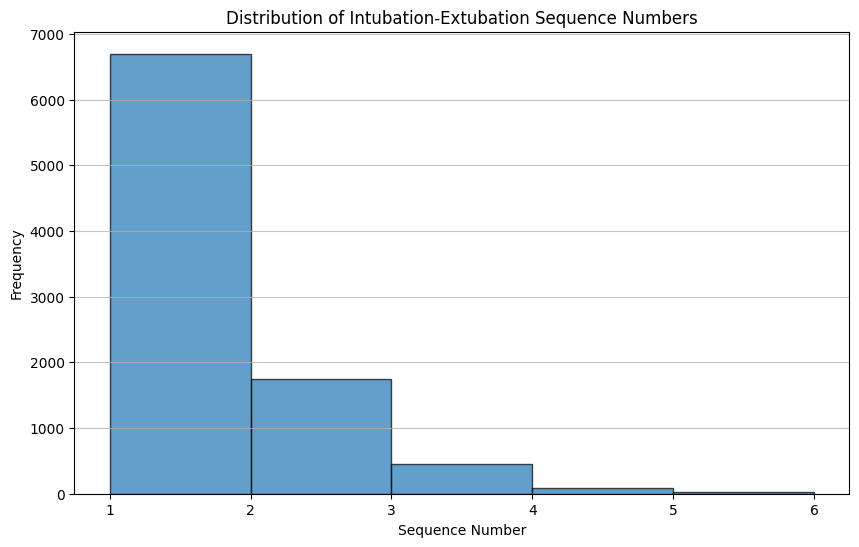

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(subjects_df['seq_num'], bins=range(1, subjects_df['seq_num'].max() + 1), edgecolor='k', alpha=0.7)
plt.title('Distribution of Intubation-Extubation Sequence Numbers')
plt.xlabel('Sequence Number')
plt.ylabel('Frequency')
plt.xticks(range(1, subjects_df['seq_num'].max() + 1))
plt.grid(axis='y', alpha=0.75)

plt.show()

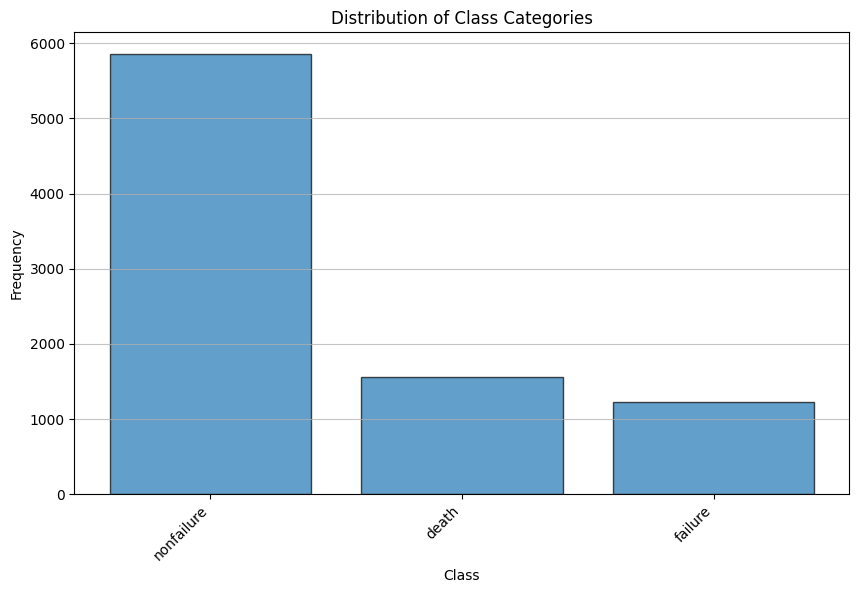

In [8]:
# Count the occurrences of each class
class_counts = subjects_df['class'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values, edgecolor='k', alpha=0.7)
plt.title('Distribution of Class Categories')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()